In [2]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyabf


In [3]:
with open("binned_waveforms.pkl", "rb") as f:
    binned_waveforms = pickle.load(f)

print("Loaded:", list(binned_waveforms.keys())[:5])  # peek at a few keys
print(len(binned_waveforms.keys()))
one_key = list(binned_waveforms.keys())[0]
binned_waveforms[one_key].head()

Loaded: [(np.float64(25.233409033558843), 'Excitatory', 'CaP', 'primary'), (np.float64(32.61578604044627), 'Excitatory', 'CaP', 'primary'), (np.float64(36.50967506389131), 'Excitatory', 'CaP', 'primary'), (np.float64(26.212319790300285), 'Excitatory', 'CaP', 'primary'), (np.float64(22.836263987212853), 'Excitatory', 'CaP', 'primary')]
14890


,Phase Bin,Current,Normalized Current,Phase
0,"(-0.001, 0.02]",-607.958923,0.382365,0.01
1,"(0.02, 0.04]",-601.768738,0.390906,0.03
2,"(0.04, 0.06]",-657.632141,0.313825,0.05
3,"(0.06, 0.08]",-623.532043,0.360877,0.07
4,"(0.08, 0.1]",-708.991272,0.242958,0.09


In [4]:
from collections import Counter

def get_freq_bin(freq):
    if 15 <= freq < 25:
        return "15–25"
    elif 25 <= freq < 35:
        return "25–35"
    elif 35 <= freq < 45:
        return "35–45"
    elif freq >= 45:
        return "45+"
    else:
        return "<15"

key_counts_all = Counter()

for freq, signal_type,cell_type, fast_slow in binned_waveforms.keys():
    freq_bin = get_freq_bin(freq)
    grouped_key = (freq_bin, signal_type, fast_slow)
    key_counts_all[grouped_key] += 1

In [15]:
list(key_counts_all)[:5]

[('25–35', 'Excitatory', 'primary'),
 ('35–45', 'Excitatory', 'primary'),
 ('15–25', 'Excitatory', 'primary'),
 ('<15', 'Excitatory', 'primary'),
 ('45+', 'Excitatory', 'primary')]

In [6]:
def average_waveforms_for_key(counter_key):
    '''
    Function that takes a counter key like ('15–25', 'Cell-attached', 'MiP', 'primary')
    Returns a DataFrame with mean and SEM of normalized current for that key
    '''
    import numpy as np

    # Separate key code
    freq_bin, signal_type, fast_slow = counter_key

    dfs = []  # To store matching waveform dataframes
    # loop through all binned waveforms
    for key in binned_waveforms.keys():
        freq, st, ct, fs = key
        # use get_freq_bin(freq) to turn float into bin, use group_iSMN() to generalize all iSMN
        if get_freq_bin(freq) == freq_bin and st == signal_type and fs == fast_slow:
            dfs.append(binned_waveforms[key].copy())

    # if no waveforms for key
    if not dfs:
        print(f"No matching waveforms found for {counter_key}")
        return None

    combined = pd.concat(dfs)

    # Compute mean and SEM per phase bin
    grouped = combined.groupby('Phase', observed=False)['Normalized Current']
    averaged = grouped.mean().reset_index(name='Normalized Current')
    sem = grouped.sem().reset_index(name='SEM')
    # Ensure SEM is float type
    sem['SEM'] = sem['SEM'].astype(float)
    # Merge mean and SEM into a single DataFrame
    result = pd.merge(averaged, sem, on='Phase')
    return result


In [7]:
one_counter_key = list(key_counts_all.keys())[0]
ex_avg_df = average_waveforms_for_key(one_counter_key)
ex_avg_df.head()

,Phase,Normalized Current,SEM
0,0.01,0.583226,0.004186
1,0.03,0.556756,0.004230
2,0.05,0.530634,0.004227
3,0.07,0.503487,0.004134
4,0.09,0.481736,0.003926


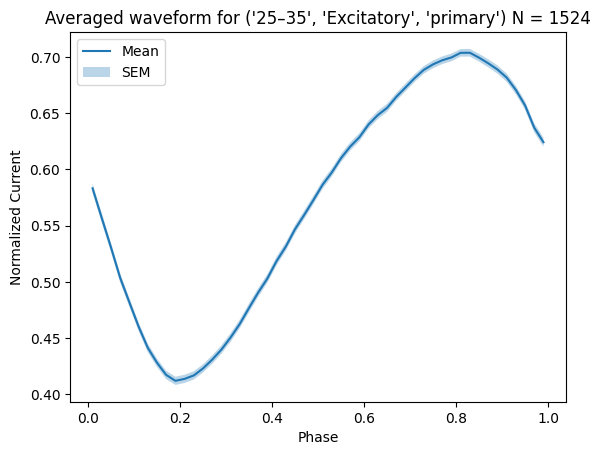

In [8]:
def plot_avg_wf(avg_waveform_df,key):
    count = key_counts_all[key]  # Get count for current key

    if avg_waveform_df is not None:
        plt.plot(avg_waveform_df['Phase'], avg_waveform_df['Normalized Current'], label='Mean')
        plt.fill_between(avg_waveform_df['Phase'],
                        avg_waveform_df['Normalized Current'] - avg_waveform_df['SEM'],
                        avg_waveform_df['Normalized Current'] + avg_waveform_df['SEM'],
                        alpha=0.3, label='SEM')
        plt.xlabel('Phase')
        plt.ylabel('Normalized Current')
        plt.title(f'Averaged waveform for {key} N = {count}')
        plt.legend()
        plt.show()

plot_avg_wf(ex_avg_df,one_counter_key)

In [21]:
key_counts_all.most_common(25)

[(('15–25', 'Cell-attached', 'primary'), 2085),
 (('25–35', 'Cell-attached', 'primary'), 1958),
 (('25–35', 'Excitatory', 'primary'), 1524),
 (('25–35', 'Inhibitory', 'Low Rin Secondary '), 1090),
 (('25–35', 'Inhibitory', 'primary'), 696),
 (('25–35', 'Cell-attached', 'High Rin Secondary'), 688),
 (('15–25', 'Cell-attached', 'High Rin Secondary'), 649),
 (('<15', 'Cell-attached', 'primary'), 600),
 (('25–35', 'Excitatory', 'Low Rin Secondary '), 599),
 (('25–35', 'Cell-attached', 'Low Rin Secondary '), 467),
 (('35–45', 'Cell-attached', 'primary'), 446),
 (('15–25', 'Excitatory', 'primary'), 322),
 (('<15', 'Excitatory', 'primary'), 320),
 (('35–45', 'Inhibitory', 'Low Rin Secondary '), 306),
 (('35–45', 'Excitatory', 'primary'), 262),
 (('15–25', 'Cell-attached', 'Low Rin Secondary '), 246),
 (('<15', 'Cell-attached', 'High Rin Secondary'), 224),
 (('35–45', 'Excitatory', 'Low Rin Secondary '), 216),
 (('25–35', 'Excitatory', 'High Rin Secondary'), 206),
 (('<15', 'Inhibitory', 'Low 

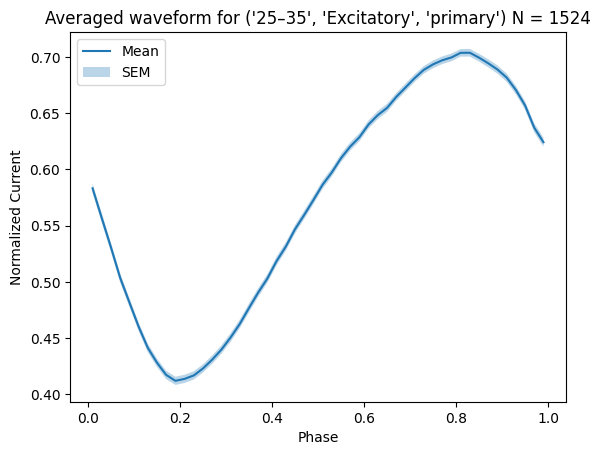

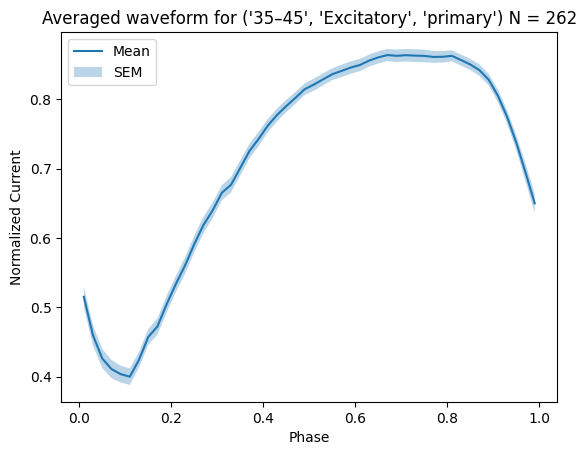

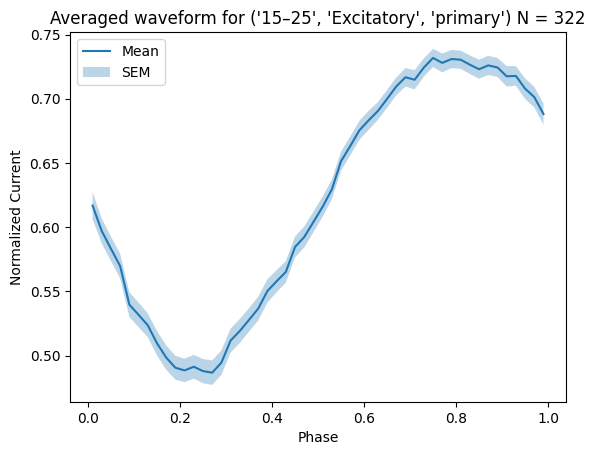

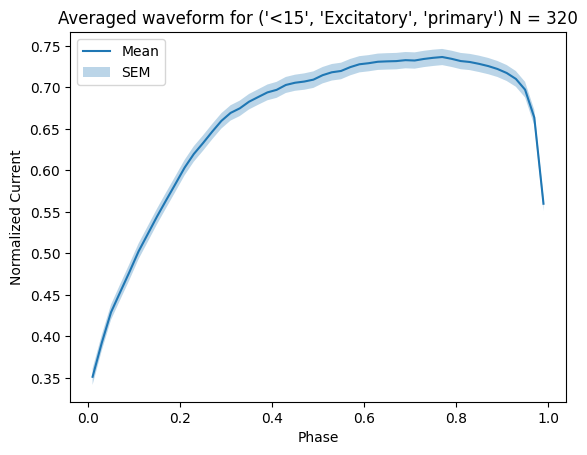

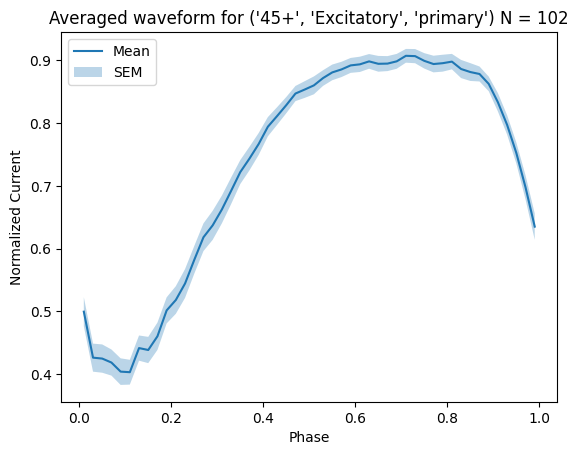

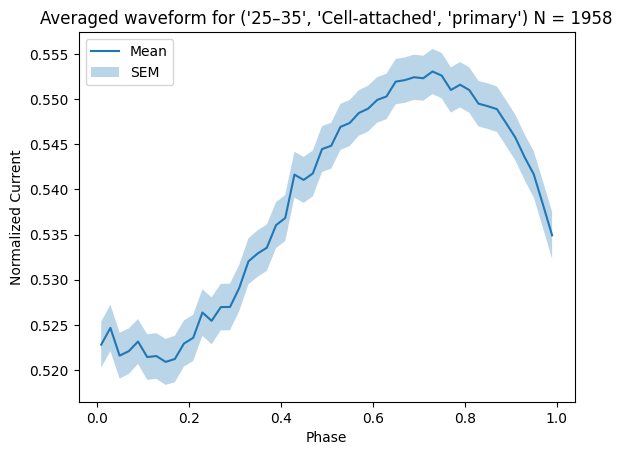

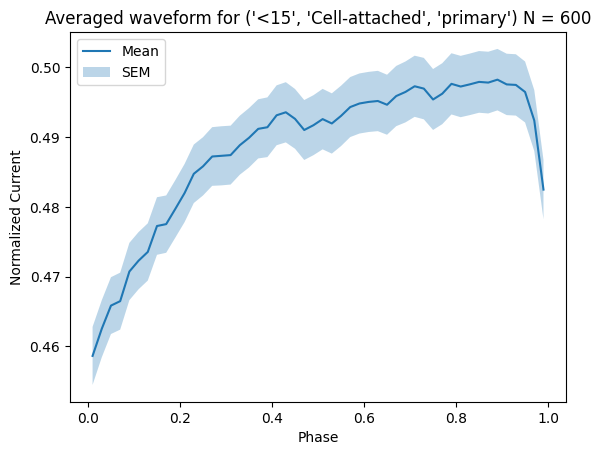

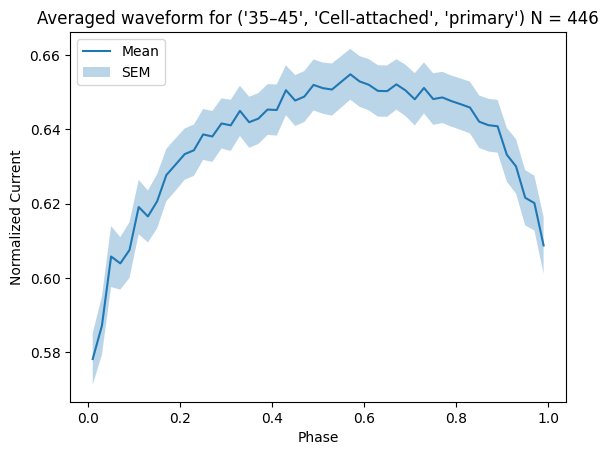

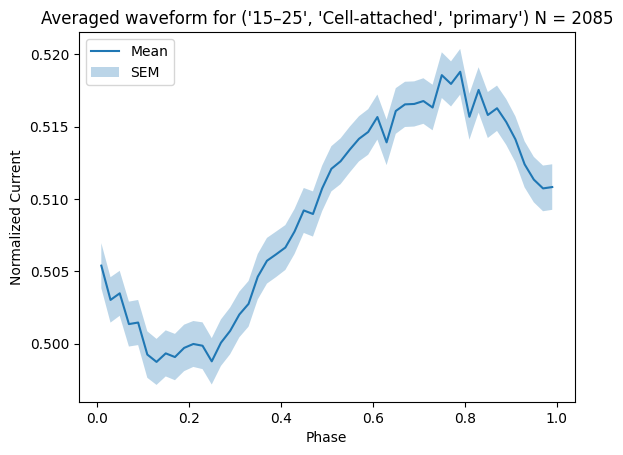

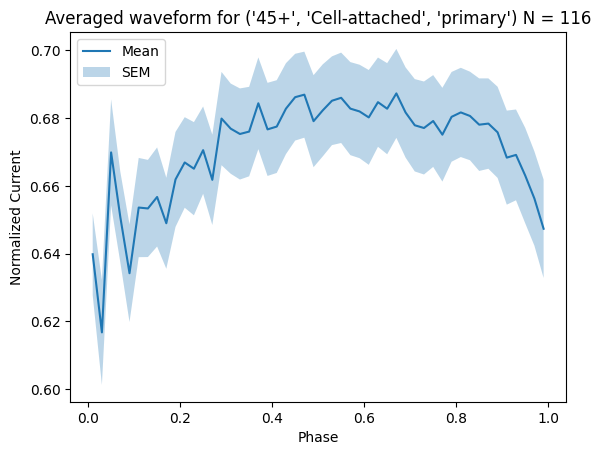

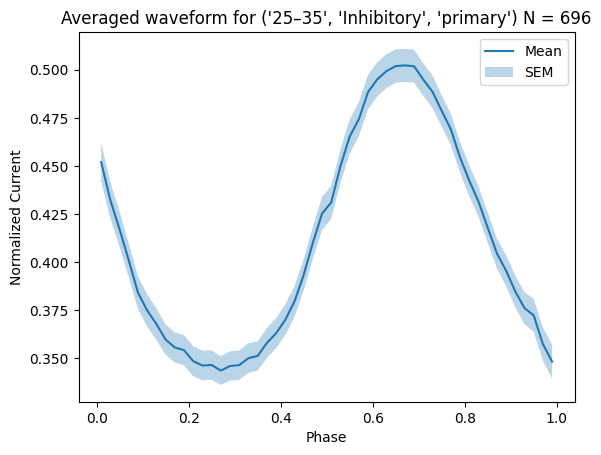

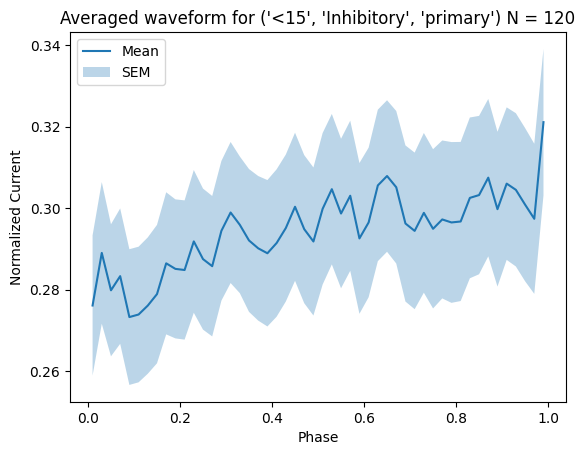

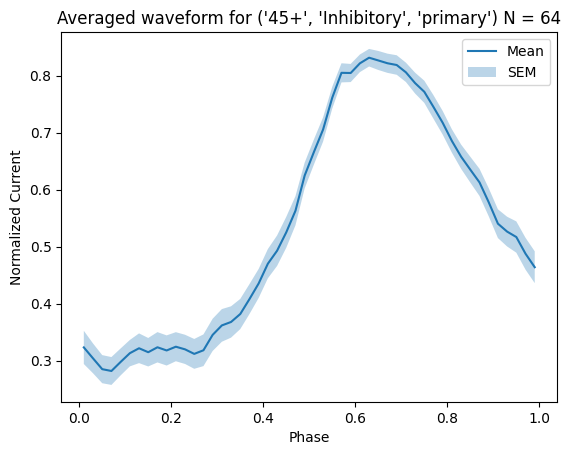

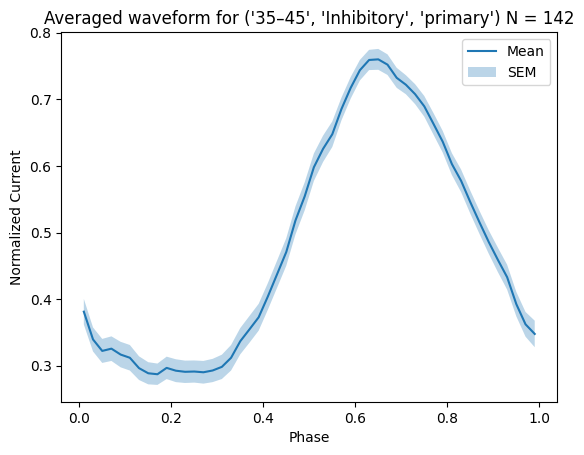

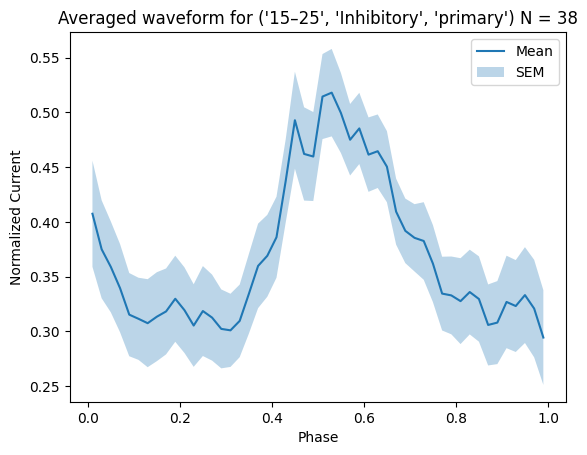

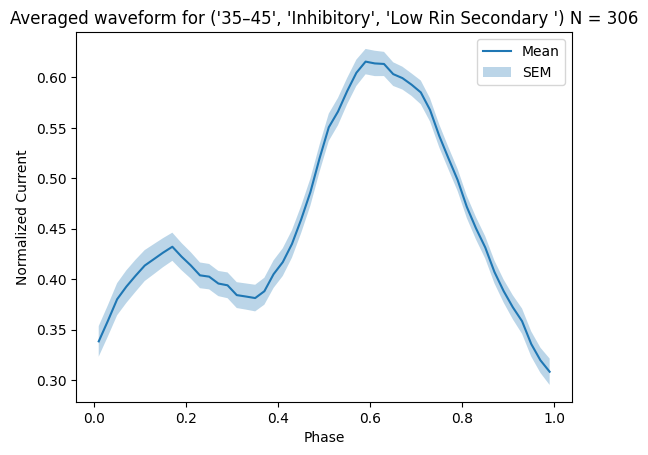

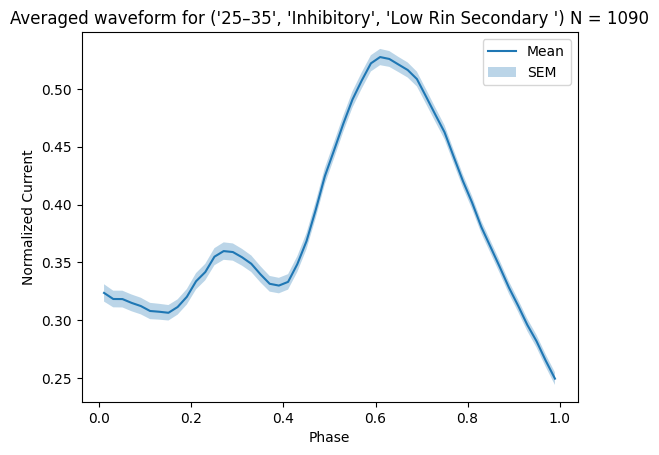

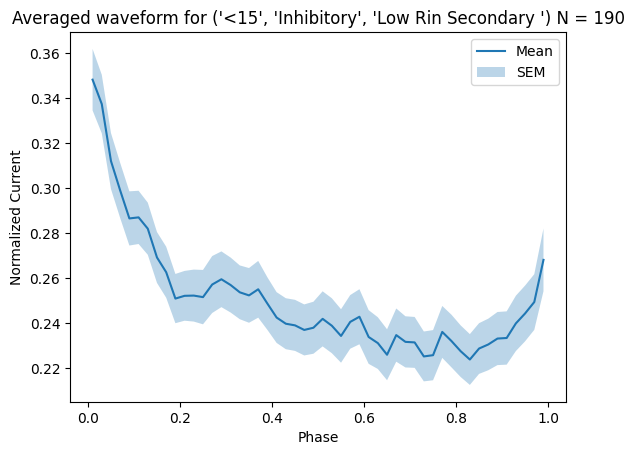

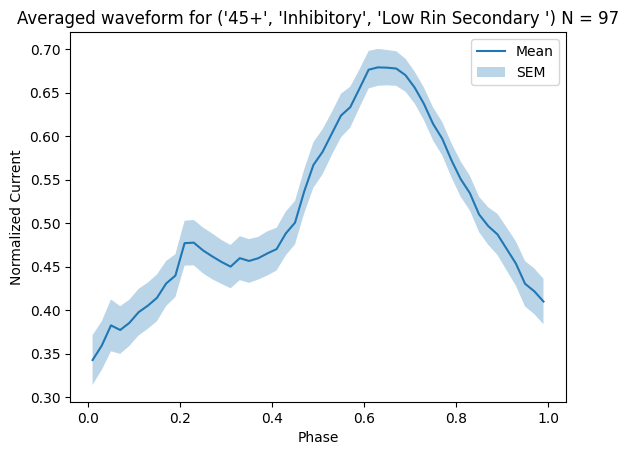

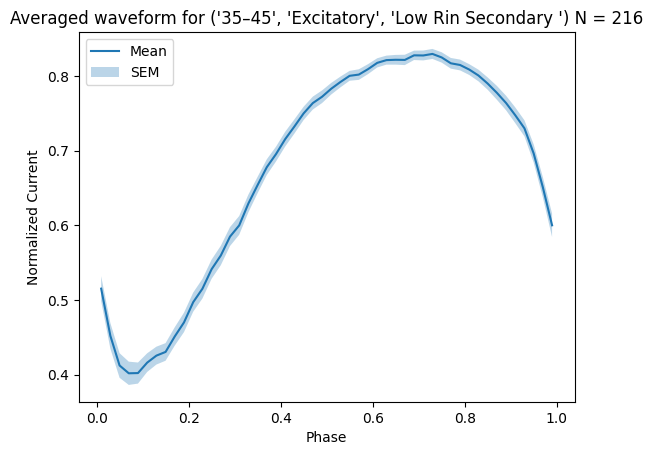

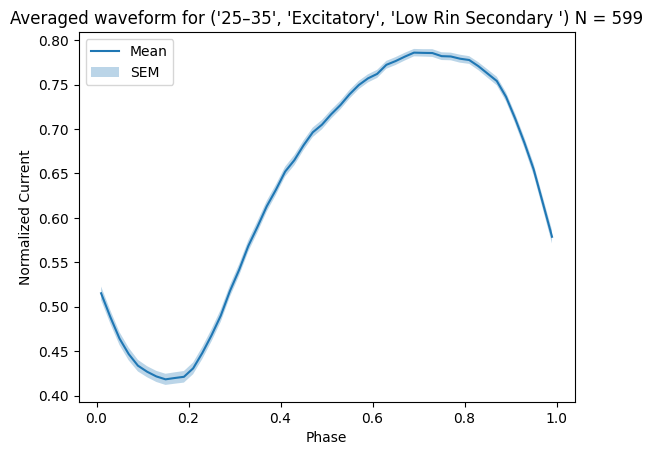

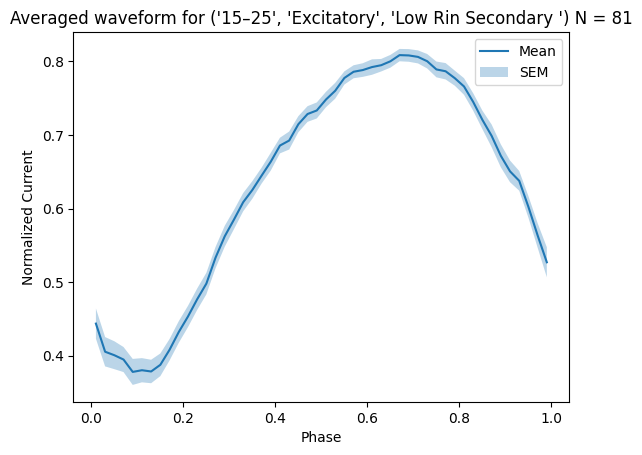

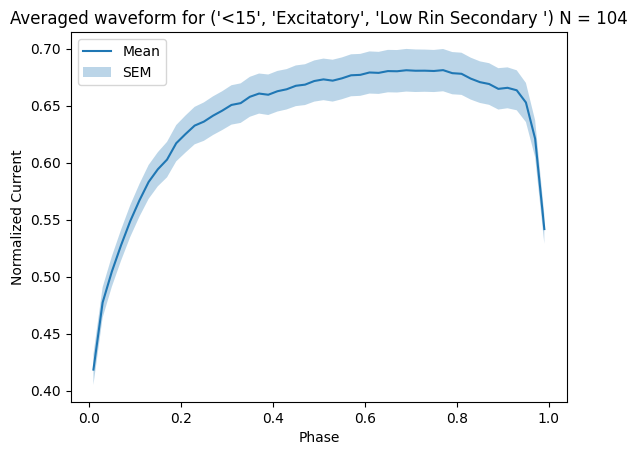

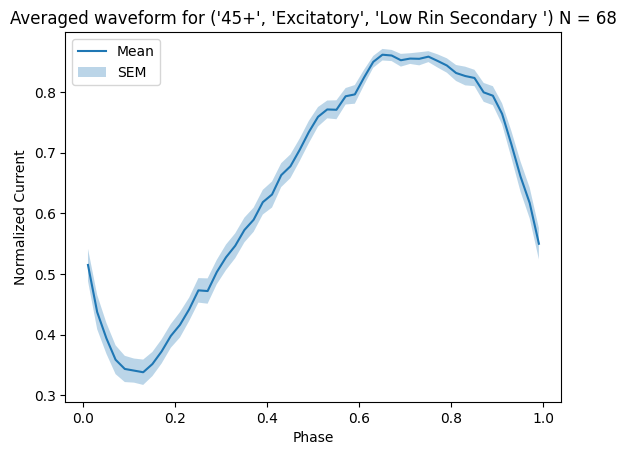

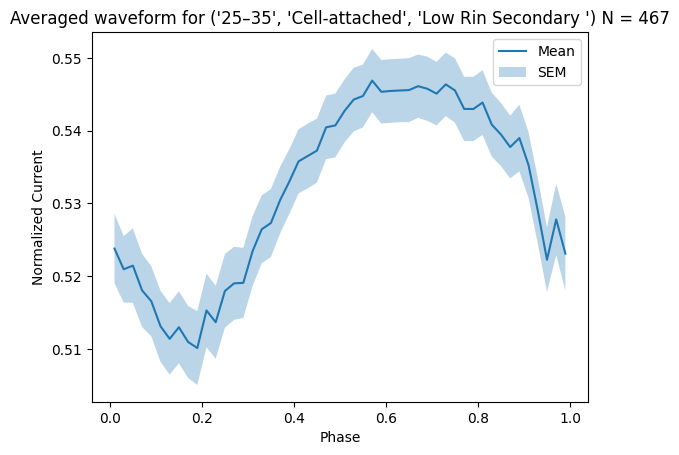

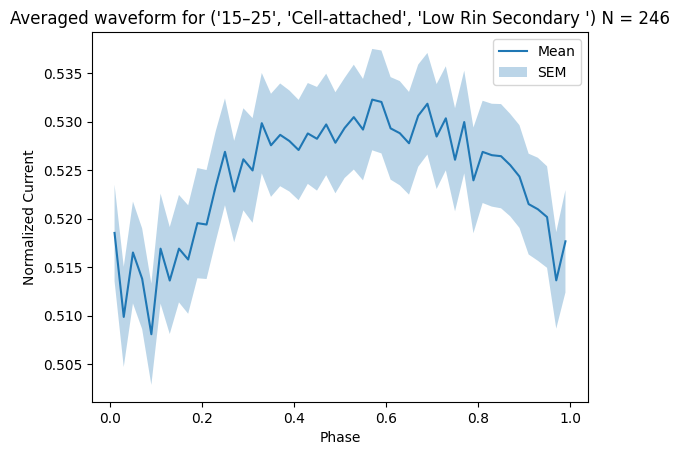

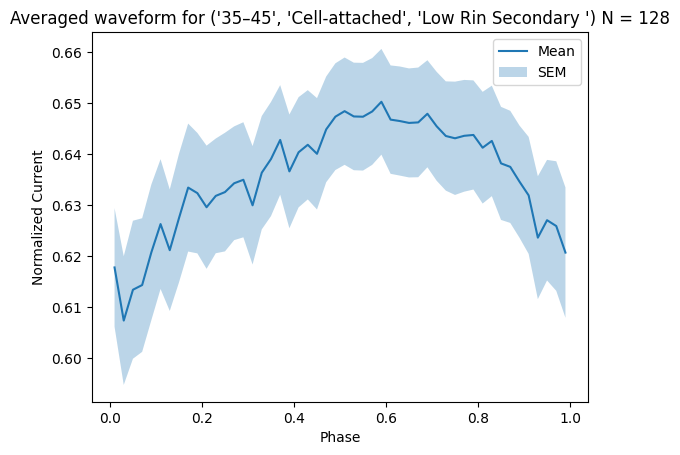

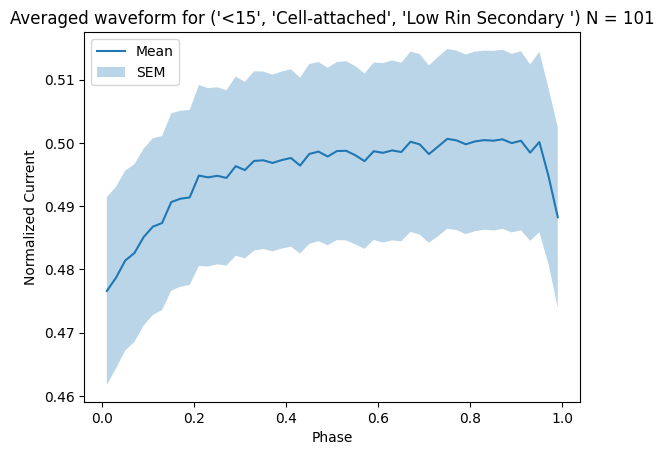

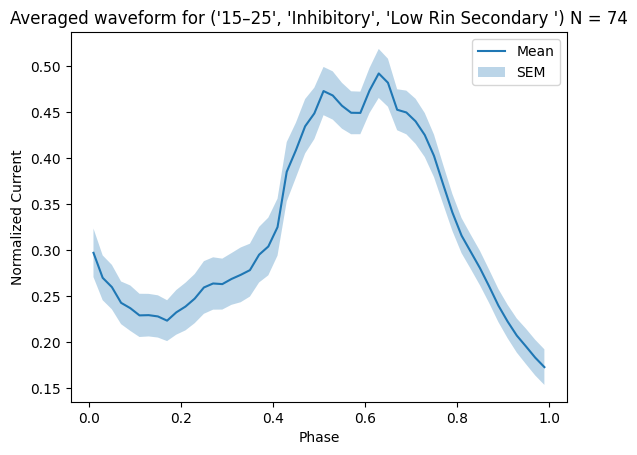

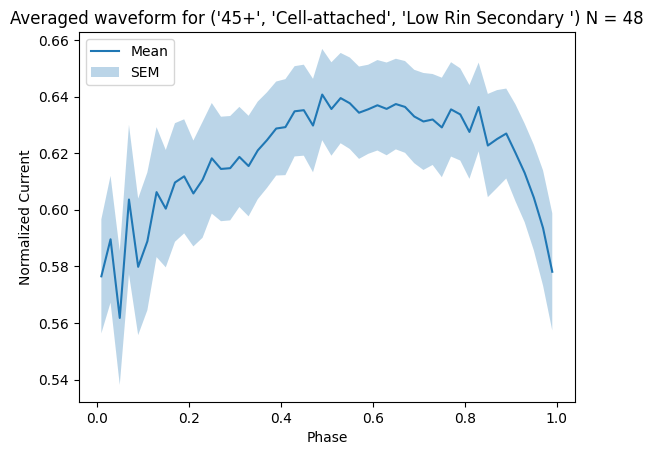

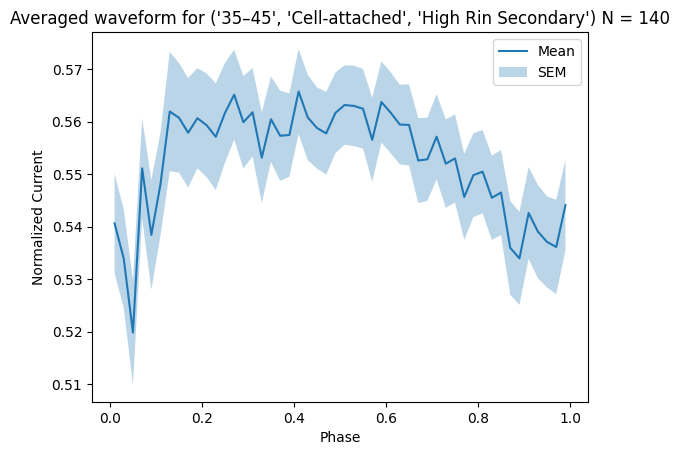

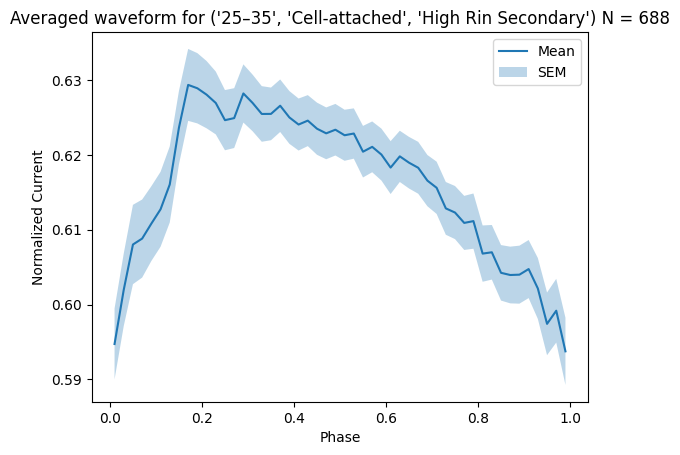

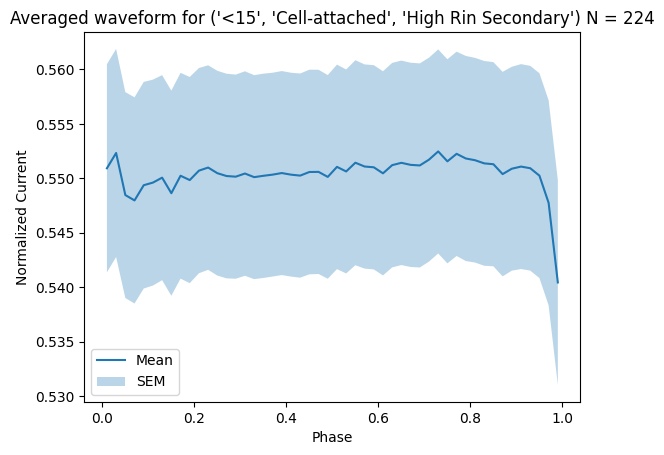

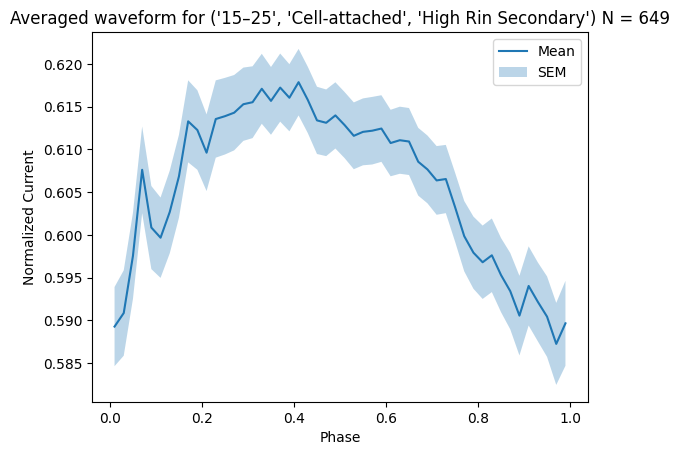

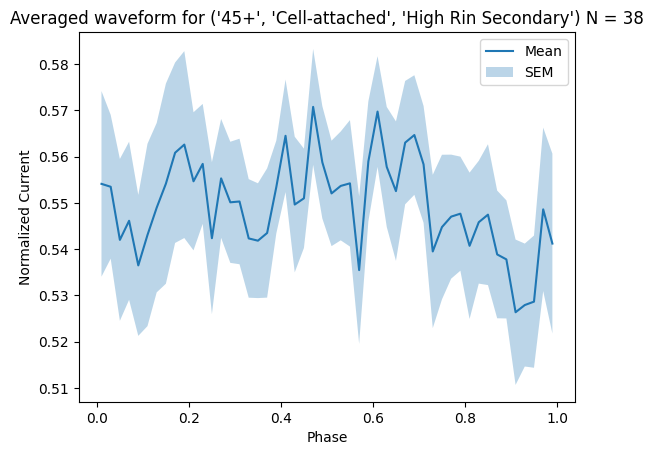

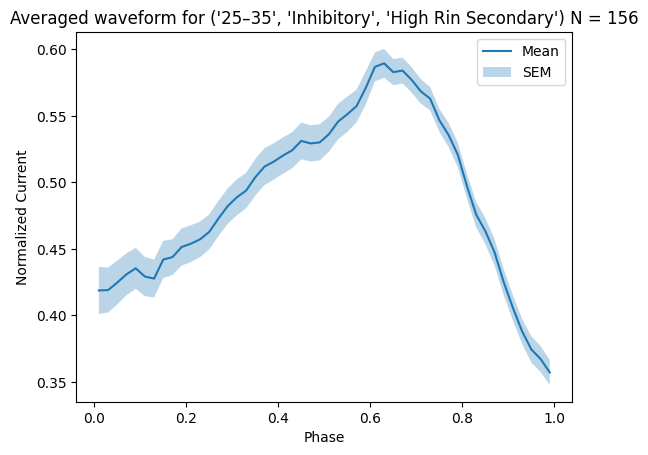

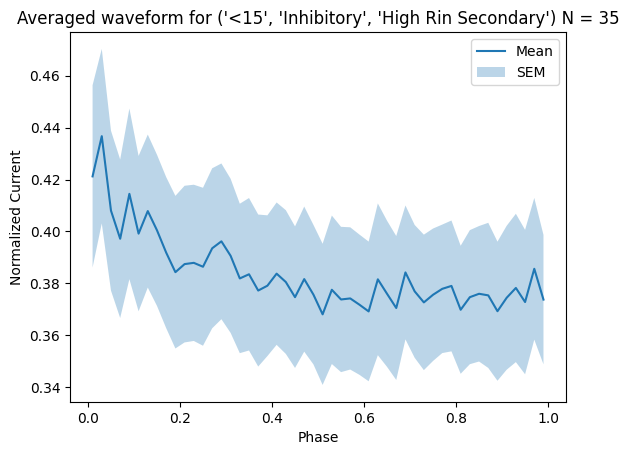

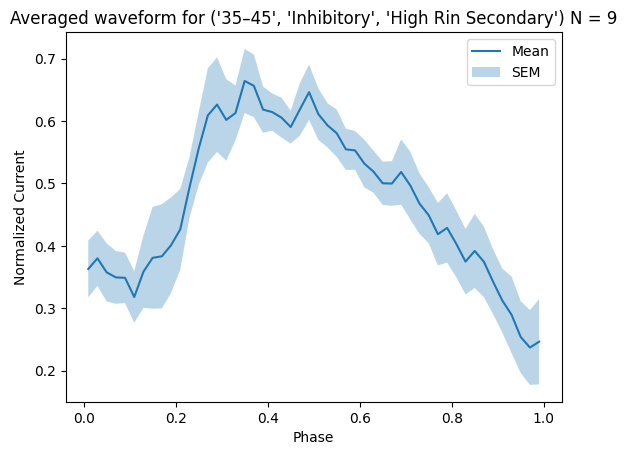

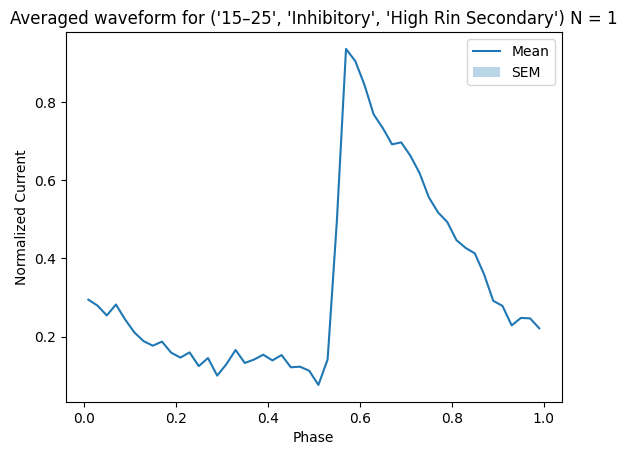

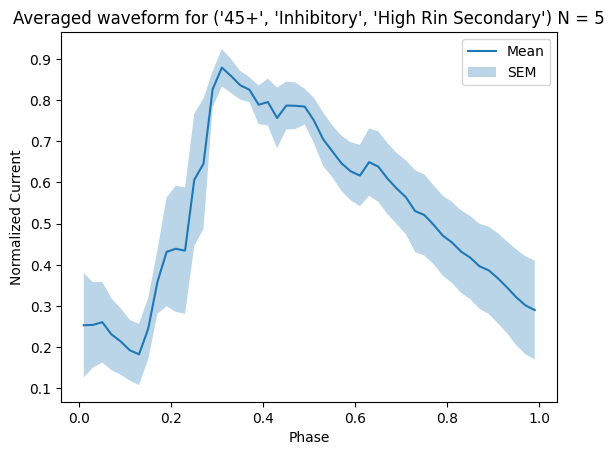

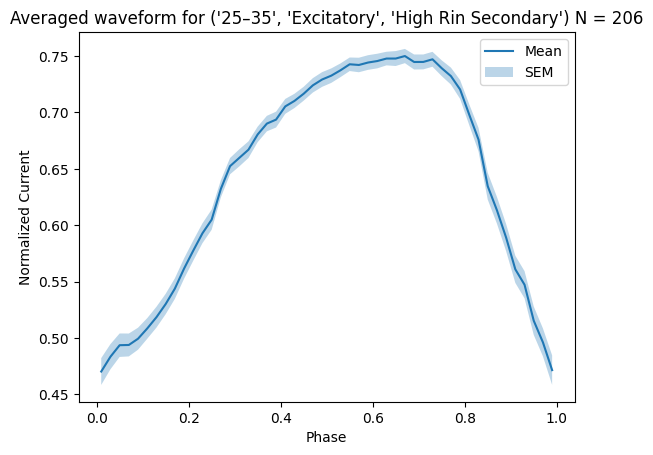

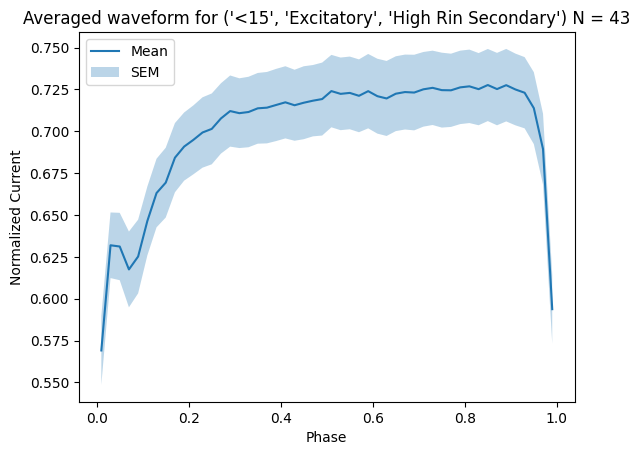

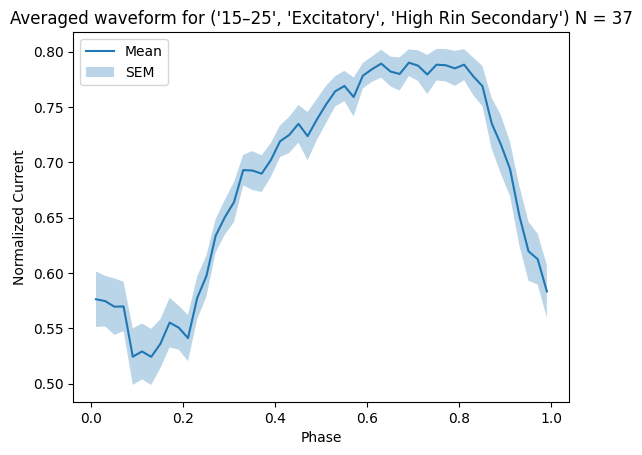

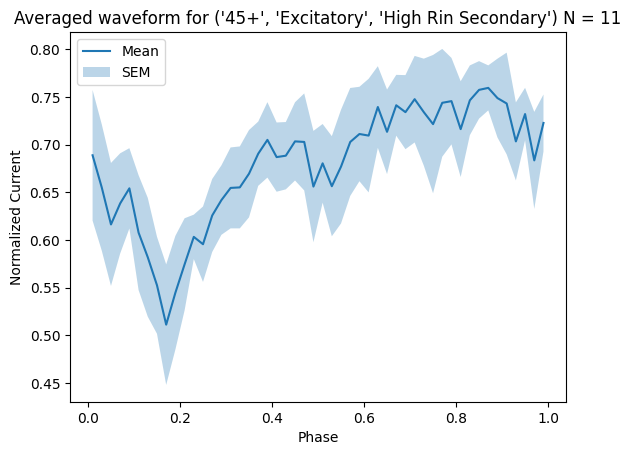

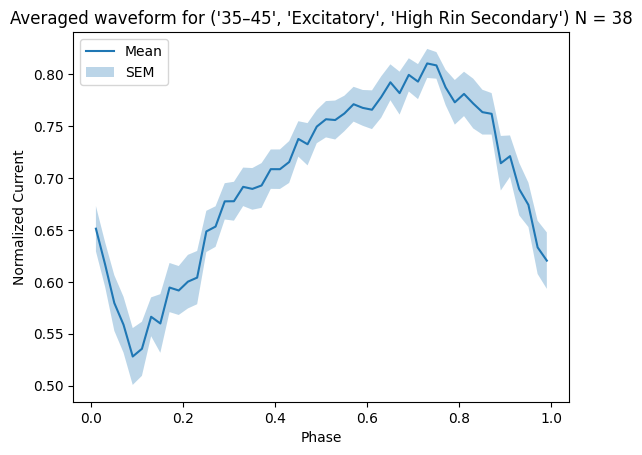

In [9]:
for key in key_counts_all.keys():
    count = key_counts_all[key]  # Get count for current key
    avg_waveform_df = average_waveforms_for_key(key)
    plot_avg_wf(avg_waveform_df,key)